## Import data

In [1]:
import pandas as pd
ATAC = pd.read_csv("data/1.ATAC-Seq data.CSV", sep=";")

# Info about the data

In [5]:
ATAC.head()

,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.41,0.71,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.41,23377.00,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,ImmGenATAC1219.peak_3,chr1,3120109,0.07,45879.00,1.0,NaN,NaN,13181.00,0.10,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,ImmGenATAC1219.peak_4,chr1,3121485,0.15,45691.00,1.0,NaN,NaN,0.41,0.10,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,ImmGenATAC1219.peak_5,chr1,3372787,0.03,11324.00,NaN,NaN,NaN,0.41,0.10,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [6]:
ATAC.shape

(512595, 98)

In [7]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Data columns (total 98 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ImmGenATAC1219.peakID            512595 non-null  object 
 1   chrom                            512595 non-null  object 
 2   Summit                           512595 non-null  int64  
 3   mm10.60way.phastCons_scores      512595 non-null  float64
 4   _-log10_bestPvalue               512595 non-null  float64
 5   Included.in.systematic.analysis  334879 non-null  float64
 6   TSS                              14292 non-null   object 
 7   genes.within.100Kb               427710 non-null  object 
 8   LTHSC.34-.BM                     512595 non-null  float64
 9   LTHSC.34+.BM                     512595 non-null  float64
 10  STHSC.150-.BM                    512595 non-null  float64
 11  MPP4.135+.BM                     512595 non-null  float64
 12  pr

In [8]:
ATAC.describe()

,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
count,5.125950e+05,512595.000000,512595.00,334879.0,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,...,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000
mean,7.596866e+07,0.164662,inf,1.0,6095.046919,12936.332385,13396.369554,14257.896763,18034.640712,17227.101166,...,19704.822925,14624.972269,19226.011170,16158.995852,14094.576211,18267.934653,17140.037676,17792.495176,22193.477680,15764.502827
std,4.450542e+07,0.203403,NaN,0.0,9788.773579,14163.202535,16375.735345,16906.870910,18783.480143,18493.944435,...,20004.913558,16857.827083,18360.437997,17876.007879,16726.326963,18369.989966,18401.952190,18063.846271,19084.434031,17767.205876
min,1.430000e+02,0.000000,0.00,1.0,0.410000,0.100000,0.110000,0.110000,0.110000,0.100000,...,0.100000,0.100000,0.110000,0.110000,0.110000,0.110000,0.100000,0.110000,0.110000,0.110000
25%,3.802562e+07,0.030000,27.55,1.0,0.410000,0.710000,0.110000,0.110000,0.470000,0.630000,...,0.770000,0.540000,0.660000,0.530000,0.520000,0.560000,0.720000,0.570000,0.640000,0.530000
50%,7.364690e+07,0.080000,23408.00,1.0,0.410000,73.770000,0.900000,27.810000,16011.000000,12420.000000,...,15462.000000,11475.000000,17319.000000,13516.000000,61.080000,17168.000000,13516.000000,15766.000000,22282.000000,13150.000000
75%,1.091549e+08,0.220000,44197.00,1.0,13181.000000,23377.000000,31048.000000,21217.000000,41365.000000,34335.000000,...,44197.000000,28856.000000,41640.000000,30468.000000,27242.000000,35065.000000,33239.000000,33604.000000,44927.000000,31413.000000
max,1.953715e+08,1.000000,inf,1.0,46017.000000,46296.000000,46296.000000,46508.000000,47453.000000,47453.000000,...,47453.000000,47423.000000,47453.000000,47453.000000,47453.000000,47453.000000,47392.000000,47178.000000,47300.000000,47453.000000


## Clustering


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [31]:
#coloums with numerical datas for Clustering
float_cols = ATAC.select_dtypes(include=['float64']).columns
print(float_cols)
ATAC_num = ATAC.select_dtypes(include=['float64'])
ATAC_num.head()

Index(['mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'LTHSC.34-.BM', 'LTHSC.34+.BM',
       'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM',
       'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp',
       'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp',
       'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM',
       'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr',
       'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp',
       'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d',
       'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th',
       'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.

,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,0.00,0.56,NaN,0.41,0.71,0.90,0.11,34335.00,0.10,0.11,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,0.00,0.50,NaN,0.41,23377.00,0.90,0.83,0.47,0.34,0.82,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,0.07,45879.00,1.0,13181.00,0.10,0.90,0.11,0.47,0.10,0.50,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,0.15,45691.00,1.0,0.41,0.10,0.11,0.11,0.79,0.40,0.50,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,0.03,11324.00,NaN,0.41,0.10,0.11,0.11,0.47,0.34,28491.00,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [32]:
#remove col: Included.in.systematic.analysis due to many NaNs - Kontrolle?
ATAC_Kmeans = ATAC_num.drop(columns=['Included.in.systematic.analysis'])
ATAC_Kmeans = ATAC_Kmeans.replace([np.inf, -np.inf], np.nan).dropna()
ATAC_Kmeans.head()

,mm10.60way.phastCons_scores,_-log10_bestPvalue,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,preB.FrD.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,0.00,0.56,0.41,0.71,0.90,0.11,34335.00,0.10,0.11,25204.00,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,0.00,0.50,0.41,23377.00,0.90,0.83,0.47,0.34,0.82,0.13,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,0.07,45879.00,13181.00,0.10,0.90,0.11,0.47,0.10,0.50,42736.00,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,0.15,45691.00,0.41,0.10,0.11,0.11,0.79,0.40,0.50,44958.00,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,0.03,11324.00,0.41,0.10,0.11,0.11,0.47,0.34,28491.00,42736.00,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [33]:
#Number of clusters ?
K = range(1, 11)
a = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_Kmeans)
    a.append(kmeans.inertia_)

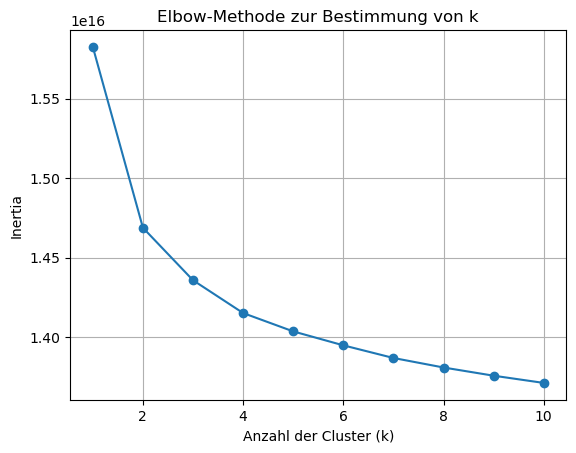

In [34]:
#Elbow-Plot zur Wahl der optimalen Clusterzahl 
plt.plot(K, a, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung von k')
plt.grid(True)
plt.show()

In [38]:
#Kein klarer Knick zu sehen, aber zwischen k=3 und k=5 flacht die Kurve ab
#Reduzierung auf 10 Dimensionen durch PCA 
pca = PCA(n_components=10)
ATAC_pca10 = pca.fit_transform(ATAC_Kmeans)

#Zur genauen bestimmung wird noch der Silhouette Score verwendet mit 10 Dimensionen
silhouette_scores = []

for k in range(2, 11):  # Silhouette macht bei k=1 keinen Sinn
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_pca10)
    score = silhouette_score(ATAC_pca10, kmeans.labels_)
    silhouette_scores.append(score)

#Plot
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette-Analyse zur Wahl von k')
plt.grid(True)
plt.show()

#da es es auch mit PCA sehr lange dauert (20 min und immernoch nicht fertig) mach ich erstmal mit elbow method weiter
#lasse das hier als markdown falls wir es doch noch machen wollen

In [41]:
#Clustering mit k=(3,4,5) ausprobieren
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3.fit(ATAC_Kmeans)

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_4.fit(ATAC_Kmeans)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_5.fit(ATAC_Kmeans)

labels_3 = kmeans_3.labels_
labels_4 = kmeans_4.labels_
labels_5 = kmeans_5.labels_

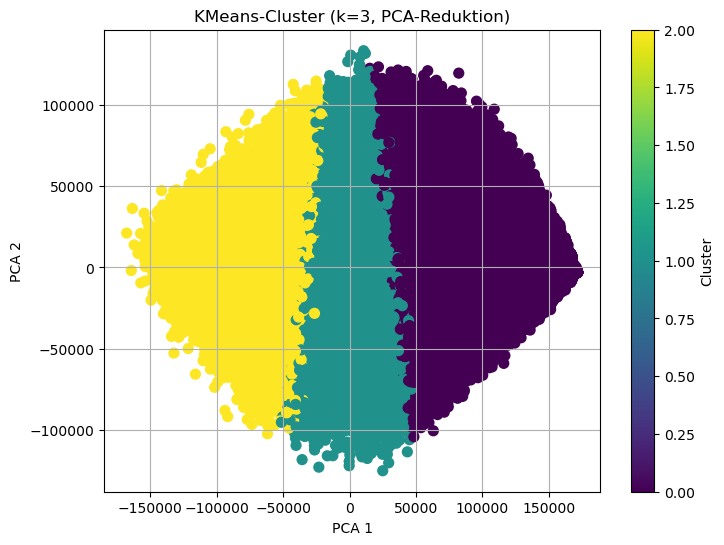

In [43]:
#Zur Visualisierung PCA und Cluster-Plot 
pca = PCA(n_components=2)
ATAC_pca = pca.fit_transform(ATAC_Kmeans)

#für k=3
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_3, cmap='viridis', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans-Cluster (k=3, PCA-Reduktion)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

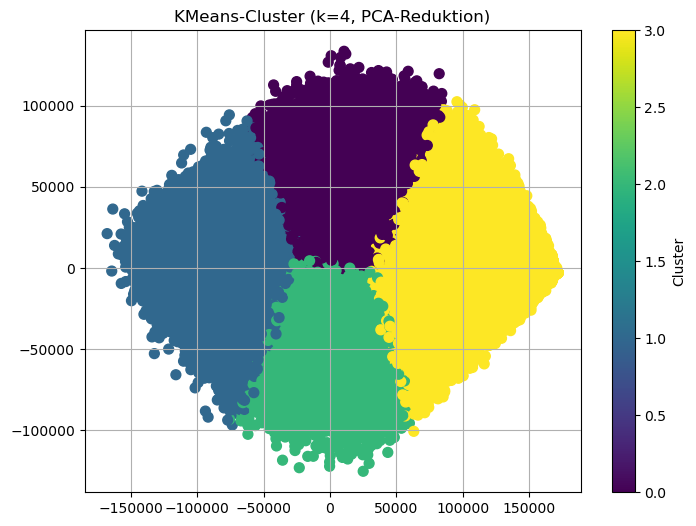

In [44]:
#für k=4
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_4, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=4, PCA-Reduktion)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

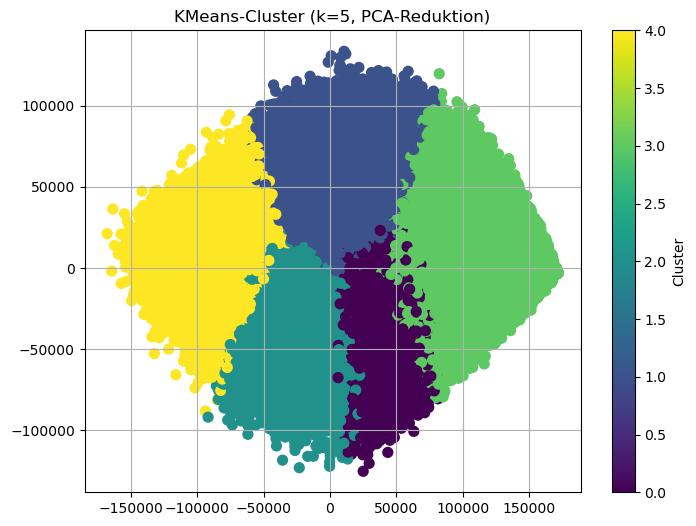

In [45]:
#für k=5
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_5, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=5, PCA-Reduktion)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

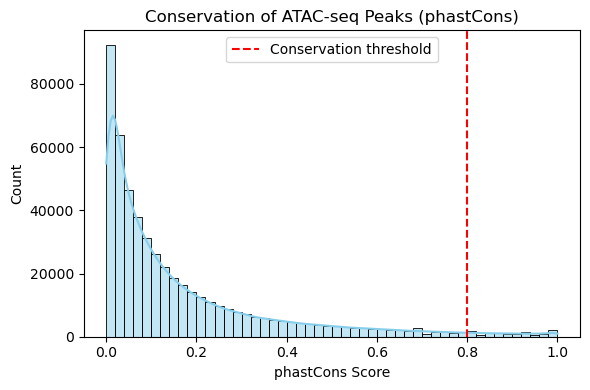

In [5]:
# PhastCons Conservation Score Distribution of ATAC-seq Peaks
phast_scores = ATAC["mm10.60way.phastCons_scores"].dropna()

plt.figure(figsize=(6, 4))
sns.histplot(phast_scores, bins=50, kde=True, color='skyblue')
plt.axvline(0.8, color='red', linestyle='--', label='Conservation threshold')
plt.xlabel('phastCons Score')
plt.title('Conservation of ATAC-seq Peaks (phastCons)')
plt.legend()
plt.tight_layout()
plt.show()


/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


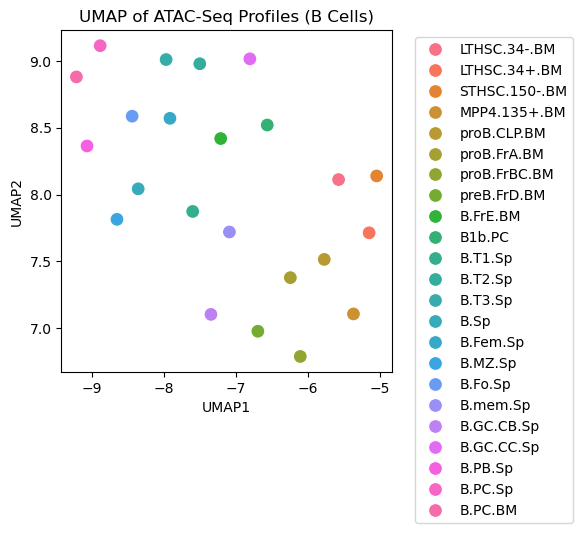

In [2]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Select the cell columns (columns 9 to 31; Python is zero-indexed, so columns 8 to 30)
cell_columns = ATAC.columns[8:31]

# Peak matrix: rows = peaks, columns = cells
signal = ATAC[cell_columns]

# Convert to numpy array
signal_values = signal.values

# Clean NaN and infinite values
signal_clean = np.nan_to_num(signal_values, nan=0.0, posinf=1e10, neginf=-1e10)

# Standardize the data
signal_scaled = StandardScaler().fit_transform(signal_clean)

# UMAP (transpose so cells are rows)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(signal_scaled.T)

# Create a DataFrame with UMAP results and cell names
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["Sample"] = cell_columns

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Sample", s=100)
plt.title("UMAP of ATAC-Seq Profiles (B Cells)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()